<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_multisource_sltm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# 1. Initialize the session
ee.Initialize(project="ee-sakda-451407")

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. INITIALIZE AND PULL DATA FROM GEE
# define basin geometry (replace with your asset or GeoJSON)
basin = ee.FeatureCollection('projects/ee-sakda-451407/assets/nan_extent')
start, end = '2010-01-01', '2022-12-31'

image_counts = {'P': 0, 'ET': 0, 'SM': 0}

def get_ts(col_id, band, name, scale=10000, agg_factor=1):
    ic = ee.ImageCollection(col_id) \
            .filterDate(start, end) \
            .filterBounds(basin)

    count = ic.size().getInfo()
    image_counts[name] = count

    if agg_factor != 1:
        # for e.g. MODIS 8-day ET to daily
        ic = ic.map(lambda img: img.select(band).divide(agg_factor)
                                .copyProperties(img, ['system:time_start']))
    def to_feature(img):
        mean = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=basin.geometry(),
            scale=scale,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            name: mean.get(band)
        })
    return ic.map(to_feature)

# precipitation
p_fc  = get_ts('UCSB-CHG/CHIRPS/DAILY', 'precipitation', 'P', scale=5000)
# evapotranspiration (MOD16A2 is 8-day total ET)
et_fc = get_ts('MODIS/061/MOD16A2GF', 'ET', 'ET', scale=500)
# soil moisture
sm_fc = get_ts('NASA/SMAP/SPL3SMP_E/005', 'soil_moisture_am', 'SM', scale=10000)

print(f"Precipitation (CHIRPS): {image_counts['P']} daily images")
print(f"Evapotranspiration (MODIS): {image_counts['ET']} 8-day composites")
print(f"Soil Moisture (SMAP): {image_counts['SM']} daily measurements")

# convert FusionTables to Pandas
def fc_to_df(fc):
    feats = fc.getInfo()['features']
    props = [f['properties'] for f in feats]
    return pd.DataFrame(props)

df = (
    fc_to_df(p_fc)
      .merge(fc_to_df(et_fc), on='date')
      .merge(fc_to_df(sm_fc), on='date')
)

print(df.shape)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# compute ΔSM and runoff proxy R = P - ET - ΔSM
df['dSM'] = df['SM'].diff().fillna(0)
df['R']   = df['P'] - df['ET'] - df['dSM']

# Add temporal features
df['day_of_year'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month

# Add rolling statistics
df['P_7d_avg'] = df['P'].rolling(window=7).mean()
df['ET_7d_avg'] = df['ET'].rolling(window=7).mean()


# keep only numeric features + target (e.g. predict R)
# features = ['P','ET','dSM']
features = ['P','ET','dSM','day_of_year']

target = 'R'
data = df[features + [target]].values



Precipitation (CHIRPS): 4747 daily images
Evapotranspiration (MODIS): 598 8-day composites
Soil Moisture (SMAP): 2747 daily measurements
(345, 4)


In [118]:
# 2. SCALE AND SEQUENCE
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# create sequences
sequence_length = 32  # use last 30 days to predict next-day runoff
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, :-1])  # all features
    y.append(data_scaled[i+sequence_length, -1])     # target column
X, y = np.array(X), np.array(y)

# train/val/test split (70/15/15)
n = len(X)
train_end = int(n*0.7)
val_end   = int(n*0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]



In [ ]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),
                      input_shape=(sequence_length, len(features))))
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True))
model.add(LSTM(32))
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

In [ ]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 1
model = Sequential()
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.2,
               input_shape=(sequence_length, len(features))))
model.add(LSTM(32,
               activation='tanh',
               dropout=0.2,
               recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

In [ ]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 2

model = Sequential()
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.2,
               input_shape=(sequence_length, len(features))))
model.add(LSTM(32,
               activation='tanh',
               dropout=0.2,
               recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

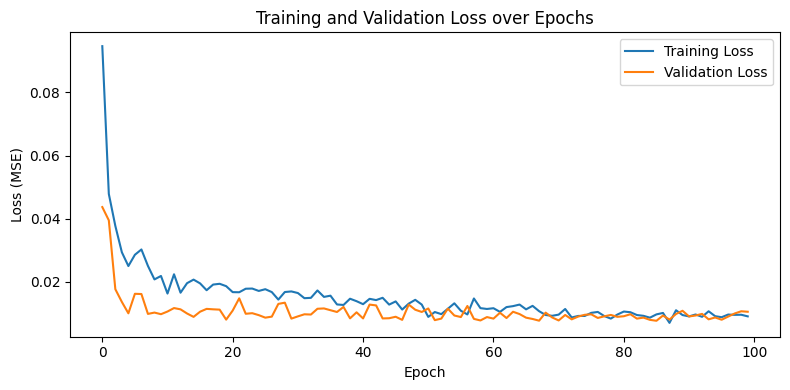

In [120]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


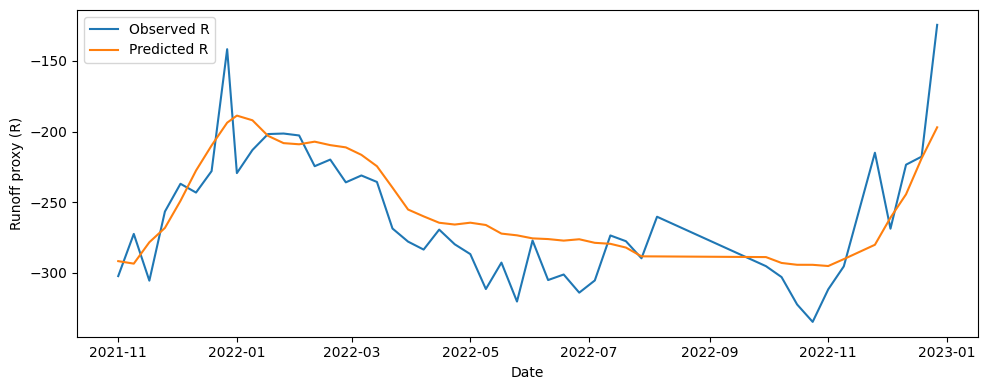

Test RMSE: 26.493, MAE: 20.954, R²: 0.663


In [121]:
# 4. EVALUATE & INVERSE-SCALE PREDICTIONS
# predict
y_pred = model.predict(X_test)

# we need to inverse-scale only the target dimension
# so rebuild full array placeholders
y_test_full  = np.zeros((len(y_test), data.shape[1]))
y_pred_full  = np.zeros_like(y_test_full)
y_test_full[:, -1] = y_test
y_pred_full[:, -1] = y_pred.flatten()

# inv_test = scaler.inverse_transform(y_test_full)[:,-1]
# inv_pred = scaler.inverse_transform(y_pred_full)[:,-1]

# compute simple metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
# y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

y_true_inv = scaler.inverse_transform(y_test_full)[:,-1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:,-1]

mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100 if np.all(y_true_inv != 0) else np.nan

# rmse = np.sqrt(mean_squared_error(inv_test, inv_pred))
# mae  = mean_absolute_error(inv_test, inv_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['date'].values[-len(y_true_inv):], y_true_inv, label='Observed R')
plt.plot(df['date'].values[-len(y_pred_inv):], y_pred_inv, label='Predicted R')
plt.xlabel('Date'); plt.ylabel('Runoff proxy (R)');
plt.legend(); plt.tight_layout(); plt.show()

print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")